# Pruebas KSWIN Modificado (configuracion 1 y 2)- Monitorización del error cometido en modelo de predicción


## Importación y carga de librerías


In [ ]:
from river import preprocessing
import pandas as pd
from river.compat import convert_sklearn_to_river
from sklearn.neural_network import MLPRegressor
from river.datasets import synth
import random
from river.drift import KSWIN 
from KSWIN_modificado import KSWIN_modificado
from river.metrics import MAE
import collections
from Lock import excel_lock
import time 


## Modelo

In [1]:



def entrenar_modelo(data): 
    model = (
        preprocessing.StandardScaler() |
        convert_sklearn_to_river(MLPRegressor(hidden_layer_sizes=(10,5), learning_rate_init=0.085,random_state=42, shuffle=True))
    )

    X = pd.DataFrame([sample for sample, target in data])
    y = pd.Series([target for sample, target in data])

    model.learn_many(X, y)

    return model


def reentrenar_modelo(data, model): 

    X = pd.DataFrame([sample for sample, target in data])
    y = pd.Series([target for sample, target in data])

    model.learn_many(X, y)

    return model



## Creación de datasets

In [ ]:
# ----------------------------------------------------------
# Función para generar un conjunto de datos con 'concept drift' simulado
# ----------------------------------------------------------
def generar_dataset_drift(tipo_drift: str, seed: int):
    """
    Genera un conjunto de datos sintético con cambios de distribución ('concept drift'),
    utilizando el generador `FriedmanDrift` de la librería `river.synth`.

    Parámetros:
    - tipo_drift (str): tipo de drift a simular. Puede ser:
        * 'abrupto' → dos cambios bruscos en puntos concretos.
        * 'gradual' → dos cambios progresivos definidos por una ventana de transición.
    - seed (int): semilla para fijar el comportamiento aleatorio (para reproducibilidad).

    Tipos de drift generados:
    - 'Drift Abrupto': dos saltos instantáneos en las posiciones 15.000 y 55.000.
    - 'Drift Gradual': cambios suaves en las mismas posiciones, definidos por un
      `transition_window` aleatorio (2000, 3000 o 4000 muestras).

    Estructura del resultado:
    - drifts (dict): diccionario con información sobre los drift generados.
        * 'drift_abrupto': lista de puntos (clave 'punto').
        * 'drift_gradual': lista de pares inicio-fin (claves 'inicio' y 'fin').
        * Otras claves ('drift_incremental', 'drift_recurrente') se devuelven vacías.
    - data (iterator): iterador con 70.000 muestras sintéticas generadas por `FriedmanDrift`.

    Retorna:
    - data (iterator): datos generados.
    - drifts (dict): estructura que detalla los puntos o intervalos donde se introdujo drift.
    """

    drifts = {
        "drift_abrupto": [],
        "drift_gradual": [],
        "drift_incremental": [],
        "drift_recurrente": []
    }

    if tipo_drift == "abrupto":
        dataset = synth.FriedmanDrift(
            drift_type='gra',
            position=(15000, 55000),
            seed = seed
        )    

        drifts["drift_abrupto"].append({"punto": 15000, "detectado": False})
        drifts["drift_abrupto"].append({"punto": 55000, "detectado": False})

        data = dataset.take(70000)


    elif tipo_drift == "gradual": 
        random.seed(seed)
        tam_window = random.choice([2000, 3000, 4000])

        dataset = synth.FriedmanDrift(
            drift_type='gsg',
            position=(15000, 55000),
            transition_window=tam_window,
            seed = seed
        )    

        drifts["drift_gradual"].append({"inicio": 15000, "fin": 15000 + tam_window, "detectado": False})
        drifts["drift_gradual"].append({"inicio": 55000, "fin": 55000 + tam_window, "detectado": False})

        data = dataset.take(70000)

    else: 
        raise ValueError("Error: el tipo de drift no existe")



    return data, drifts



    

## Funciones utilizadas en la experimentación


### Función para graficar 

In [ ]:
# ----------------------------------------------------------
# Función para visualizar un conjunto de datos con 'concept drift' (versión simplificada)
# ----------------------------------------------------------
def plot_data_2(dataset, drift_detectados, drifts):
    """
    Visualiza un conjunto de datos unidimensional con líneas verticales que indican
    los puntos o intervalos donde se ha simulado o detectado un 'concept drift'.

    Esta versión está pensada para representar únicamente los valores del dataset sin leyendas ni etiquetas adicionales,
    permitiendo una visualización más limpia o enfocada en la inspección visual rápida del comportamiento.

    Parámetros:
    - dataset (np.ndarray): valores del conjunto de datos (eje Y).
    - drift_detectados (list[int] o None): lista de posiciones en las que un modelo ha detectado drift.
      Estas detecciones se muestran como líneas rojas discontinuas.
    - drifts (dict): estructura que almacena los drift reales generados. Puede contener:
        * 'drift_abrupto': lista con claves 'punto'.
        * 'drift_gradual': lista de intervalos con claves 'inicio' y 'fin'.
        * 'drift_incremental': lista de intervalos (inicio-fin).
        * 'drift_recurrente': lista de intervalos (inicio-fin).

    Estilo de las líneas:
    - Rojo (`'r'`): detecciones realizadas por el modelo.
    - Azul (`'b'`): drift abrupto.
    - Verde (`'g'`): drift gradual.
    - Marrón (`'brown'`): drift incremental.
    - Amarillo (`'y'`): drift recurrente.

    Retorna:
    - No retorna nada. Muestra una figura mediante `matplotlib.pyplot`.
    """


    #Quiero mas valores en el eje x

    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])


    #Se muestra los valores de las métricas que estan dentro del diccionario mediciones_metricas, cada una en un color

    ax0 = plt.subplot(gs[0])
    ax0.set_title('Dataset')
    ax0.plot(dataset, 'o')
    ax0.set_ylabel('Valor')

    if drift_detectados is not None:
        for punto in drift_detectados:
            ax0.axvline(x=punto, color='r', linestyle='--')


    for punto in drifts["drift_abrupto"]:
        ax0.axvline(x=punto.get("punto"), color='b', linestyle='--')

    for punto in drifts["drift_gradual"]:
        ax0.axvline(x=punto.get("inicio"), color='g', linestyle='--')
        ax0.axvline(x=punto.get("fin"), color='g', linestyle='--')

    for punto in drifts["drift_incremental"]:
        ax0.axvline(x=punto.get("inicio"), color='brown', linestyle='--')
        ax0.axvline(x=punto.get("fin"), color='brown', linestyle='--')

    for punto in drifts["drift_recurrente"]:
        ax0.axvline(x=punto.get("inicio"), color='y', linestyle='--')
        ax0.axvline(x=punto.get("fin"), color='y', linestyle='--')
    

    plt.show()

### Detección de drift

In [ ]:

# ----------------------------------------------------------
# Función para detectar concept drift durante la predicción de un modelo online
# ----------------------------------------------------------
def realizar_deteccion_2(model, dataset, drifts, detector, longitud_batch, imprimir_mensajes: bool = True):
    """
    Evalúa un modelo online sobre un conjunto de datos y aplica un detector de drift
    (KSWIN o KSWIN_modificado) sobre el error absoluto del modelo, para identificar 
    si hay cambios en el comportamiento del sistema.

    Parámetros:
    - model: modelo de regresión online compatible con `river` (debe tener `.predict_many()`).
    - dataset: iterador de pares (sample, target) provenientes de `river.datasets` o similar.
    - drifts (dict): información estructurada de los drift simulados (ver estructura de entrada).
    - detector: instancia de KSWIN o KSWIN_modificado.
    - longitud_batch (int): número de errores que se acumulan antes de aplicar el test de detección.
    - imprimir_mensajes (bool): si True, imprime en consola cuando se detecta un drift.

    Retorna:
    - puntos_detectados (list): índices donde el detector indicó un cambio.
    - medicion_metricas (dict): evolución del error absoluto (y MAE) en cada paso.
    - falsas_alarmas (list): detecciones fuera de las regiones con drift real.
    """

    # Se inicializa una ventana para acumular errores antes de aplicar el test
    if isinstance(detector, KSWIN_modificado):
        batch_detector = collections.deque(maxlen=longitud_batch)
    else:
        batch_detector = collections.deque(maxlen=1)

    # Métricas de rendimiento que se monitorizan
    metricas = {
        "MAE": MAE()
    }

    # Donde se irán almacenando los valores de error
    medicion_metricas = {
        "MAE": [],
        "Error": []
    }

    puntos_detectados = []       # Detecciones realizadas por el detector
    pila_reentreno = []          # Datos que se acumulan para reentrenar el modelo tras un drift
    rellenar_pila_drift = False  # Flag que indica si hay que empezar a acumular datos
    falsas_alarmas = []          # Detecciones fuera de zona real de drift

    for i, (sample, target) in enumerate(iter(dataset)):

        # Si estamos en fase post-detección → acumular datos para reentrenar
        if rellenar_pila_drift:
            pila_reentreno.append((sample, target))

            # Cuando se acumulan 10.000 muestras → reentrenar modelo y resetear detector
            if len(pila_reentreno) >= 10000:
                model = reentrenar_modelo(pila_reentreno, model)
                pila_reentreno = []
                rellenar_pila_drift = False
                metricas = {"MAE": MAE()}  # reiniciar métricas

                # Reiniciar detector
                if isinstance(detector, KSWIN_modificado):
                    detector = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000,
                                                stat_size=300, confirm_drift=False, 
                                                alternative='two-sided', es_continua=True)
                else:
                    detector = KSWIN(alpha=0.001, window_size=3000, stat_size=300)

        # Predicción del modelo
        X = pd.DataFrame([sample])
        prediction = model.predict_many(X).iloc[0]

        # Actualización de métricas si hay predicción válida
        if prediction is not None:
            metricas["MAE"].update(target, prediction)
            medicion_metricas["MAE"].append(metricas["MAE"].get())
            medicion_metricas["Error"].append(abs(target - prediction))

        # Verificación para registrar punto clave del drift (aunque no se usa después aquí)
        for punto in drifts["drift_abrupto"]:
            if punto.get("punto") == i or punto.get("punto") == i + 2000:
                iteracciones = 0
                break
        for punto in drifts["drift_gradual"]:
            if punto.get("inicio") == i or punto.get("fin") == i:
                iteracciones = 0
                break
        for punto in drifts["drift_incremental"]:
            if punto.get("inicio") == i or punto.get("fin") == i:
                iteracciones = 0
                break
        for punto in drifts["drift_recurrente"]:
            if punto.get("inicio") == i or punto.get("fin") == i:
                iteracciones = 0
                break

        # Se calcula el error para usarlo como señal de entrada al detector
        error_actual = abs(target - prediction)
        batch_detector.append(error_actual)

        # Si se llena la ventana de errores, se aplica el test de detección
        if len(batch_detector) == batch_detector.maxlen:

            if isinstance(detector, KSWIN_modificado):
                detector.update(batch_detector)
            else:
                detector.update(error_actual)

            batch_detector.clear()

            # Si se detecta un cambio → guardar, verificar si es falso positivo
            if detector.drift_detected and not rellenar_pila_drift:
                if imprimir_mensajes:
                    print(f'Drift detectado en el índice {i}')

                rellenar_pila_drift = True  # activar fase de reentrenamiento
                flag = True  # se asume falsa alarma hasta comprobar lo contrario

                # Comprobación con cada tipo de drift: si la detección cae dentro de una ventana real
                for punto in drifts["drift_abrupto"]:
                    if punto.get("punto") < i < punto.get("punto") + 2000:
                        punto["detectado"] = True
                        flag = False
                        break
                for punto in drifts["drift_gradual"]:
                    if punto.get("inicio") < i < punto.get("fin"):
                        punto["detectado"] = True
                        flag = False
                        break
                for punto in drifts["drift_incremental"]:
                    if punto.get("inicio") < i < punto.get("fin"):
                        punto["detectado"] = True
                        flag = False
                        break
                for punto in drifts["drift_recurrente"]:
                    if punto.get("inicio") < i < punto.get("fin"):
                        punto["detectado"] = True
                        flag = False
                        break

                if flag:
                    falsas_alarmas.append(i)

                puntos_detectados.append(i)

    return puntos_detectados, medicion_metricas, falsas_alarmas




### Cálculo de métricas y estadísticas. Escritura de archivo con resultados.

In [ ]:


# ----------------------------------------------------------
# Función para guardar y registrar estadísticas de detección y rendimiento
# ----------------------------------------------------------
def guardar_estadisticas(detector, tipo_drift, drifts_totales, falsas_alarmas, puntos_detectados, mediciones_metricas, tiempo_ejecucion):
    """
    Calcula, muestra y guarda en un archivo Excel las métricas clave de un experimento
    de detección de 'concept drift', incluyendo FDR, MDR y valores medios de error.

    Parámetros:
    - detector (str): nombre del detector utilizado (usado como nombre de hoja en el Excel).
    - tipo_drift (str): tipo de drift evaluado ('abrupt', 'gradual', etc.).
    - drifts_totales (list[dict]): lista con los diccionarios de drift generados en cada ejecución.
    - falsas_alarmas (list[list[int]]): lista de listas con los índices de falsas alarmas detectadas.
    - puntos_detectados (list[list[int]]): lista de listas con los índices de detección correcta o no.
    - mediciones_metricas (dict): contiene listas con los valores de métricas (Error, MAE, etc.).
    - tiempo_ejecucion (float): duración del experimento en segundos.

    Salida:
    - Muestra por consola los valores calculados.
    - Guarda los resultados en un archivo Excel con una hoja por detector.
    """

    # Calcular total de detecciones (TP + FP) y número de falsas alarmas (FP)
    totales = sum(len(aux) for aux in puntos_detectados)
    len_aux = sum(len(aux) for aux in falsas_alarmas)

    if totales != 0:
        FDR = round(len_aux / totales, 5)  # False Discovery Rate = FP / (TP + FP)
        print(f"FDR: {FDR}")
    else:
        FDR = None

    # Calcular FN y TP recorriendo los drift reales
    FN = 0
    TP = 0
    for drifts in drifts_totales:
        for dr in drifts:
            for punto in drifts[dr]:
                if not punto["detectado"]:
                    FN += 1
                else:
                    TP += 1

    MDR = round(FN / (FN + TP), 5)  # Missed Detection Rate = FN / (FN + TP)
    print(f"MDR: {MDR}")

    # Calcular medias de las métricas (ej. Error, MAE)
    estadisticas_metricas = {}
    for metrica in mediciones_metricas:
        media = sum(mediciones_metricas[metrica]) / len(mediciones_metricas[metrica])
        print(f"Media de la métrica {metrica}: {media}")
        estadisticas_metricas[metrica] = {"Media": media}

    # Crear DataFrame con resultados para guardar
    df = pd.DataFrame([{
        "tipo_drift": tipo_drift,
        "FDR": FDR,
        "MDR": MDR,
        "tiempo_ejecucion": tiempo_ejecucion,
        "Media_Error": estadisticas_metricas["Error"]["Media"],
        "Media_MAE": estadisticas_metricas["MAE"]["Media"]
    }])

    nombre_archivo = "estadisticas_pruebas_Modelo_prediccion.xlsx"

    # Guardar estadísticas en el Excel bajo control de acceso concurrente
    with excel_lock:
        try:
            with pd.ExcelFile(nombre_archivo) as xls:
                # Si ya existe una hoja con ese detector → actualizar
                if detector in xls.sheet_names:
                    df_aux = pd.read_excel(xls, sheet_name=detector)

                    matching_rows = df_aux[(df_aux["tipo_drift"] == df["tipo_drift"].iloc[0])]

                    if not matching_rows.empty:
                        # Si ya existe una fila para ese tipo de drift → sobreescribir
                        index_existente = matching_rows.index[0]
                        df_aux.iloc[index_existente] = df.iloc[0]
                    else:
                        df_aux = pd.concat([df_aux, df], ignore_index=True)

                    with pd.ExcelWriter(nombre_archivo, engine='openpyxl', mode='a') as writer:
                        writer.book.remove(writer.book[detector])  # Eliminar hoja previa
                        df_aux.to_excel(writer, sheet_name=detector, index=False)
                else:
                    # Si la hoja no existe aún → crearla directamente
                    with pd.ExcelWriter(nombre_archivo, engine='openpyxl', mode='a') as writer:
                        df.to_excel(writer, sheet_name=detector, index=False)

        except FileNotFoundError:
            # Si el archivo no existe → crearlo desde cero
            with pd.ExcelWriter(nombre_archivo, engine='openpyxl') as writer:
                df.to_excel(writer, sheet_name=detector, index=False)

        except Exception as e:
            print(f"Error general: {e}")

    

### Pruebas

In [ ]:
iteracciones_totales = 1000


#### KSWIN

#### Abrupto


RuntimeError: matplotlib does not support generators as input

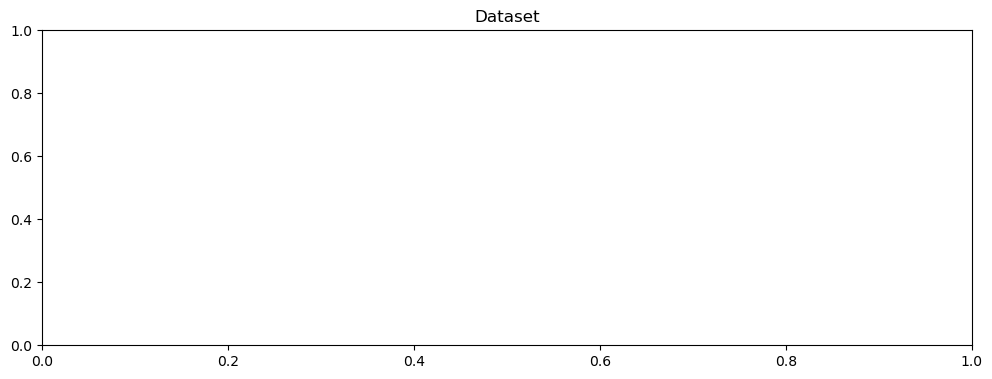

In [ ]:


falsas_alarmas = []
puntos_detectados = []
medicion_metricas = {
    "MAE": [], 
    "Error": []
}
tiempo_total = 0
drifts_totales = []


for i in range(iteracciones_totales):

    data = list(synth.Friedman(seed=42+i).take(100000))

    modelo = entrenar_modelo(data)

    metrica = []

    data_test, drifts = generar_dataset_drift("abrupto", 23+i)

    detector = KSWIN(alpha=0.001, window_size=3000, stat_size=300,seed=42)

    tiempo_inicial = time.time()    

    puntos_detectados_aux, mediciones_metricas_aux, falsas_alarmas_aux = realizar_deteccion_2(modelo, data_test, drifts, detector, 300, False)

    tiempo_total = time.time() - tiempo_inicial

    puntos_detectados.append(puntos_detectados_aux)
    falsas_alarmas.append(falsas_alarmas_aux)

    for key in mediciones_metricas_aux.keys():
        medicion_metricas[key].extend(mediciones_metricas_aux[key])
    drifts_totales.append(drifts)






In [62]:
guardar_estadisticas("KSWIN", "abrupto", drifts_totales, falsas_alarmas, puntos_detectados, medicion_metricas, tiempo_total)

FAR: 0.8
MDR: 0.5
Media de la metrica MAE: 2.2524034575939806
Media de la metrica Error: 2.4256656149923748


#### Gradual

In [ ]:


falsas_alarmas = []
puntos_detectados = []
medicion_metricas = {
    "MAE": [], 
    "Error": []
}
tiempo_total = 0
drifts_totales = []


for i in range(iteracciones_totales):

    data = list(synth.Friedman(seed=42+i).take(100000))

    modelo = entrenar_modelo(data)

    metrica = []

    data_test, drifts = generar_dataset_drift("gradual", 23+i)

    detector = KSWIN(alpha=0.001, window_size=3000, stat_size=300,seed=42)

    tiempo_inicial = time.time()    

    puntos_detectados_aux, mediciones_metricas_aux, falsas_alarmas_aux = realizar_deteccion_2(modelo, data_test, drifts, detector, 300, False)

    tiempo_total = time.time() - tiempo_inicial

    puntos_detectados.append(puntos_detectados_aux)
    falsas_alarmas.append(falsas_alarmas_aux)

    for key in mediciones_metricas_aux.keys():
        medicion_metricas[key].extend(mediciones_metricas_aux[key])
    drifts_totales.append(drifts)


In [72]:
guardar_estadisticas("KSWIN", "gradual", drifts_totales, falsas_alarmas, puntos_detectados, medicion_metricas, tiempo_total)

FAR: 0.8
MDR: 0.5
Media de la metrica MAE: 2.1372091014182253
Media de la metrica Error: 2.3145554558728287


#### KSWIN MODIFICADO

#### Abrupto (Configuracion 1)


Drift detectado en el índice 15299
Drift detectado en el índice 55199


RuntimeError: matplotlib does not support generators as input

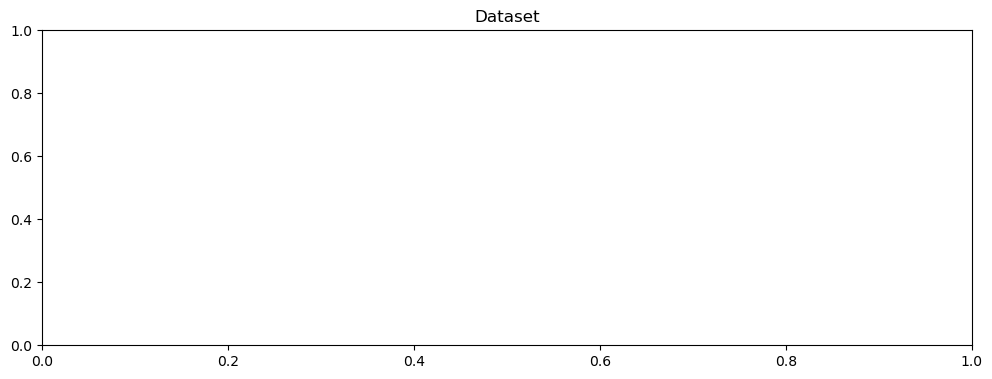

In [ ]:


falsas_alarmas = []
puntos_detectados = []
medicion_metricas = {
    "MAE": [], 
    "Error": []
}
tiempo_total = 0
drifts_totales = []


for i in range(iteracciones_totales):

    data = list(synth.Friedman(seed=42+i).take(100000))

    modelo = entrenar_modelo(data)

    metrica = []

    data_test, drifts = generar_dataset_drift("abrupto", 23+i)

    detector = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000, stat_size=300, confirm_drift=False, alternative='two-sided', es_continua=True, configuracion=1)

    tiempo_inicial = time.time()    

    puntos_detectados_aux, mediciones_metricas_aux, falsas_alarmas_aux = realizar_deteccion_2(modelo, data_test, drifts, detector, 300, False)

    tiempo_total = time.time() - tiempo_inicial

    puntos_detectados.append(puntos_detectados_aux)
    falsas_alarmas.append(falsas_alarmas_aux)

    for key in mediciones_metricas_aux.keys():
        medicion_metricas[key].extend(mediciones_metricas_aux[key])
    drifts_totales.append(drifts)

    # plot_data_2(mediciones_metricas_aux["Error"], puntos_detectados_aux, drifts)


    



In [ ]:
guardar_estadisticas("KSWIN_Modificado (config original)", "abrupto", drifts_totales, falsas_alarmas, puntos_detectados, medicion_metricas, tiempo_total)

FAR: 0.0
MDR: 0.0
Media de la metrica MAE: 1.9767252492397853
Media de la metrica Error: 2.285783598924508


In [69]:
# import numpy as np
# import matplotlib.pyplot as plt
# from statsmodels.nonparametric.kernel_regression import KernelReg

# plt.plot(mediciones_metricas["Error"][14000:16000], 'o')

# plt.show()



# # Datos simulados
# np.random.seed(123)
# x = np.linspace(0,2000, 2000)
# y = mediciones_metricas["Error"][14000:16000]

# # Ajuste no paramétrico
# kr = KernelReg(y, x, var_type='c')  # 'c' indica que x es continua
# y_pred, dy_dx = kr.fit(x)  # Obtiene la estimación de y y su derivada

# # Gráfico de la estimación y la derivada
# plt.figure(figsize=(8, 5))
# plt.scatter(x, y, label="Datos", alpha=0.5)
# plt.plot(x, y_pred, label="Estimación de y", color="blue") 
# # plt.plot(x, dy_dx, label="Primera derivada", color="red")
# plt.legend()
# plt.title("Regresión no paramétrica y su derivada")
# plt.show()

# plt.figure(figsize=(8, 5))
# plt.plot(x, dy_dx, label="Primera derivada", color="red")
# plt.legend()
# plt.show()

#### Abrupto (Configuracion 2)

In [ ]:


falsas_alarmas = []
puntos_detectados = []
medicion_metricas = {
    "MAE": [], 
    "Error": []
}
tiempo_total = 0
drifts_totales = []


for i in range(iteracciones_totales):

    data = list(synth.Friedman(seed=42+i).take(100000))

    modelo = entrenar_modelo(data)

    metrica = []

    data_test, drifts = generar_dataset_drift("abrupto", 23+i)

    detector = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000, stat_size=300, confirm_drift=False, alternative='two-sided', es_continua=True, configuracion=2)

    tiempo_inicial = time.time()    

    puntos_detectados_aux, mediciones_metricas_aux, falsas_alarmas_aux = realizar_deteccion_2(modelo, data_test, drifts, detector, 300, False)

    tiempo_total = time.time() - tiempo_inicial

    puntos_detectados.append(puntos_detectados_aux)
    falsas_alarmas.append(falsas_alarmas_aux)

    for key in mediciones_metricas_aux.keys():
        medicion_metricas[key].extend(mediciones_metricas_aux[key])
    drifts_totales.append(drifts)

    # plot_data_2(mediciones_metricas_aux["Error"], puntos_detectados_aux, drifts)


    



In [ ]:
guardar_estadisticas("KSWIN_Modificado", "abrupto", drifts_totales, falsas_alarmas, puntos_detectados, medicion_metricas, tiempo_total)

#### Gradual (Configuracion 1)

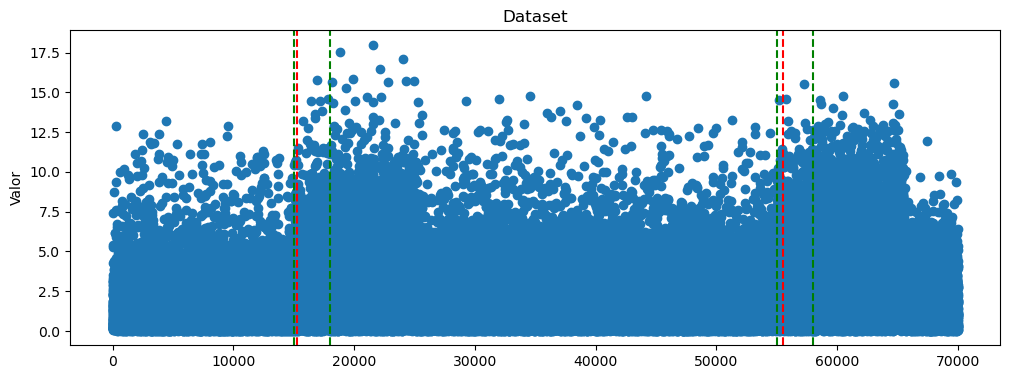

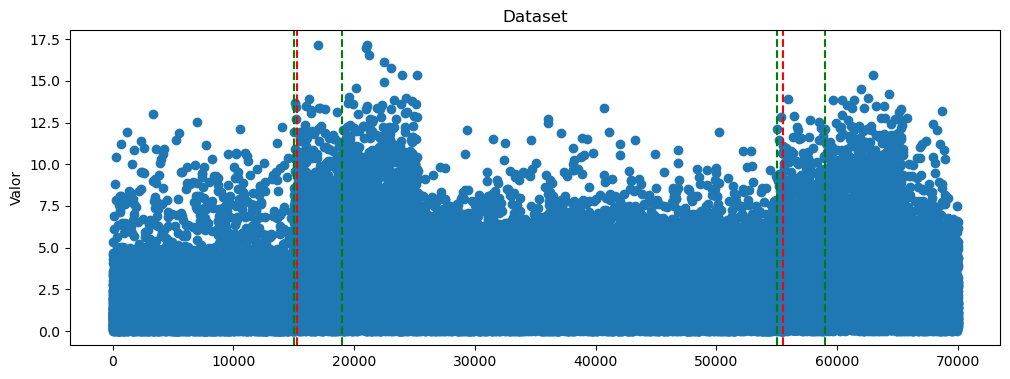

In [ ]:
f


falsas_alarmas = []
puntos_detectados = []
medicion_metricas = {
    "MAE": [], 
    "Error": []
}
tiempo_total = 0
drifts_totales = []


for i in range(iteracciones_totales):

    data = list(synth.Friedman(seed=42+i).take(100000))

    modelo = entrenar_modelo(data)

    metrica = []

    data_test, drifts = generar_dataset_drift("gradual", 23+i)

    detector = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000, stat_size=300, confirm_drift=False, alternative='two-sided', es_continua=True, configuracion=1)

    tiempo_inicial = time.time()    

    puntos_detectados_aux, mediciones_metricas_aux, falsas_alarmas_aux = realizar_deteccion_2(modelo, data_test, drifts, detector, 300, False)

    tiempo_total = time.time() - tiempo_inicial

    puntos_detectados.append(puntos_detectados_aux)
    falsas_alarmas.append(falsas_alarmas_aux)

    for key in mediciones_metricas_aux.keys():
        medicion_metricas[key].extend(mediciones_metricas_aux[key])
    drifts_totales.append(drifts)

    # plot_data_2(mediciones_metricas_aux["Error"], puntos_detectados_aux, drifts)


    



In [ ]:
guardar_estadisticas("KSWIN_Modificado (config original)", "gradual", drifts_totales, falsas_alarmas, puntos_detectados, medicion_metricas, tiempo_total)

FAR: 0.0
MDR: 0.0
Media de la metrica MAE: 1.9767252492397853
Media de la metrica Error: 2.285783598924508


In [76]:
# import numpy as np
# import matplotlib.pyplot as plt
# from statsmodels.nonparametric.kernel_regression import KernelReg

# plt.plot(mediciones_metricas["Error"][14000:18000], 'o')

# plt.show()



# # Datos simulados
# np.random.seed(123)
# x = np.linspace(0,4000, 4000)
# y = mediciones_metricas["Error"][14000:18000]

# # Ajuste no paramétrico
# kr = KernelReg(y, x, var_type='c')  # 'c' indica que x es continua
# y_pred, dy_dx = kr.fit(x)  # Obtiene la estimación de y y su derivada

# # Gráfico de la estimación y la derivada
# plt.figure(figsize=(8, 5))
# plt.scatter(x, y, label="Datos", alpha=0.5)
# plt.plot(x, y_pred, label="Estimación de y", color="blue") 
# # plt.plot(x, dy_dx, label="Primera derivada", color="red")
# plt.legend()
# plt.title("Regresión no paramétrica y su derivada")
# plt.show()

# plt.figure(figsize=(8, 5))
# plt.plot(x, dy_dx, label="Primera derivada", color="red")
# plt.legend()
# plt.show()

#### Gradual (configuracion 2)

In [ ]:



falsas_alarmas = []
puntos_detectados = []
medicion_metricas = {
    "MAE": [], 
    "Error": []
}
tiempo_total = 0
drifts_totales = []


for i in range(iteracciones_totales):

    data = list(synth.Friedman(seed=42+i).take(100000))

    modelo = entrenar_modelo(data)

    metrica = []

    data_test, drifts = generar_dataset_drift("gradual", 23+i)

    detector = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000, stat_size=300, confirm_drift=False, alternative='two-sided', es_continua=True, configuracion=2)

    tiempo_inicial = time.time()    

    puntos_detectados_aux, mediciones_metricas_aux, falsas_alarmas_aux = realizar_deteccion_2(modelo, data_test, drifts, detector, 300, False)

    tiempo_total = time.time() - tiempo_inicial

    puntos_detectados.append(puntos_detectados_aux)
    falsas_alarmas.append(falsas_alarmas_aux)

    for key in mediciones_metricas_aux.keys():
        medicion_metricas[key].extend(mediciones_metricas_aux[key])
    drifts_totales.append(drifts)

    # plot_data_2(mediciones_metricas_aux["Error"], puntos_detectados_aux, drifts)


    



In [ ]:
guardar_estadisticas("KSWIN_Modificado", "gradual", drifts_totales, falsas_alarmas, puntos_detectados, medicion_metricas, tiempo_total)